In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Epoch 1/300: 100%|██████████| 147/147 [00:01<00:00, 130.86it/s, loss=1.91]
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 300/300: 100%|██████████| 147/147 [00:00<00:00, 152.86it/s, loss=0.263]


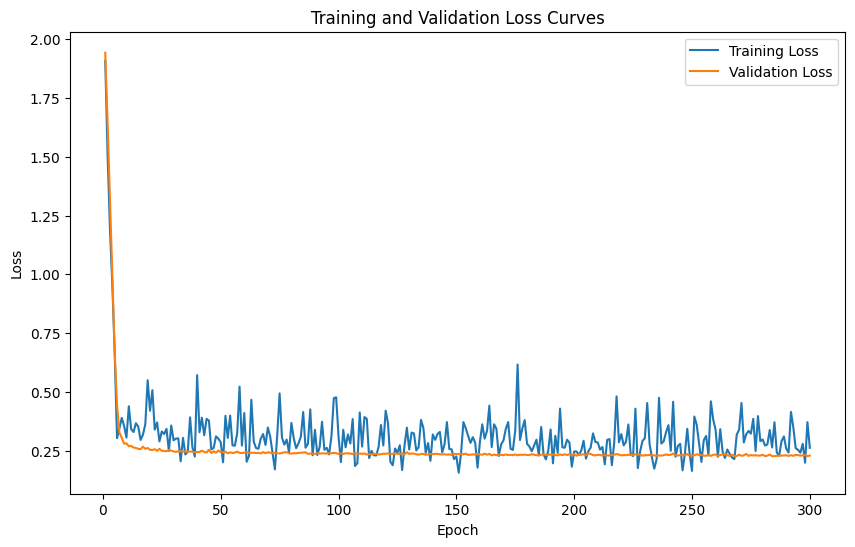

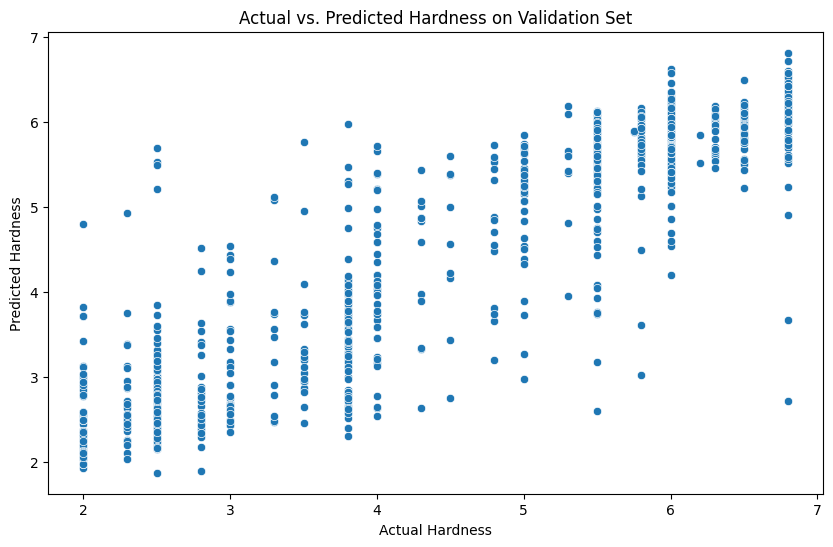

Median Absolute Error on Validation Set: 0.31882333755493164


In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import median_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the datasets
train_dataset = pd.read_csv(r"/kaggle/input/playground-series-s3e25/train.csv")
test_dataset = pd.read_csv(r"/kaggle/input/playground-series-s3e25/test.csv")

# Winsorize each column independently
percentile = 5
numerical_columns = train_dataset.select_dtypes(include=['number']).columns
train_dataset[numerical_columns] = train_dataset[numerical_columns].apply(lambda x: winsorize(x, limits=(percentile / 100, percentile / 100)).data)

percentile = 5
numerical_columns_test = test_dataset.select_dtypes(include=['number']).columns
test_dataset[numerical_columns_test] = test_dataset[numerical_columns_test].apply(lambda x: winsorize(x, limits=(percentile / 100, percentile / 100)).data)


# Interaction Terms
train_dataset['interaction_term_1'] = train_dataset['density_Total'] * train_dataset['allelectrons_Average']
train_dataset['interaction_term_2'] = train_dataset['val_e_Average'] * train_dataset['atomicweight_Average']

test_dataset['interaction_term_1'] = test_dataset['density_Total'] * test_dataset['allelectrons_Average']
test_dataset['interaction_term_2'] = test_dataset['val_e_Average'] * test_dataset['atomicweight_Average']

features = ['density_Total', 'allelectrons_Average',
            'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
            'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
            'zaratio_Average', 'density_Average', 'interaction_term_1', 'interaction_term_2']

# Standardize the features using StandardScaler
scaler = StandardScaler()
train_dataset[features] = scaler.fit_transform(train_dataset[features])
test_dataset[features] = scaler.transform(test_dataset[features].values)


X = torch.tensor(train_dataset[features].values, dtype=torch.float32)
y = torch.tensor(train_dataset['Hardness'].values, dtype=torch.float32).view(-1, 1)

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Train LGBMRegressor model
# lgbm_model = LGBMRegressor(n_estimators=200, max_depth=7, random_state=1, num_leaves=35)
lgbm_model = LGBMRegressor(boosting_type= 'gbdt', colsample_bytree = 0.8, learning_rate= 0.15, min_child_samples = 19, n_estimators= 300, num_leaves= 40, reg_alpha= 10, reg_lambda= 1, subsample= 0.9)
lgbm_model.fit(train_dataset[features], train_dataset['Hardness'])

# Add LGBMRegressor predictions to the features
train_dataset['lgbm_Pred'] = lgbm_model.predict(train_dataset[features])
test_dataset['lgbm_Pred'] = lgbm_model.predict(test_dataset[features])

# Append LGBMRegressor predictions to the features
X = torch.tensor(train_dataset[features + ['lgbm_Pred']].values, dtype=torch.float32) 
X_test = torch.tensor(test_dataset[features + ['lgbm_Pred']].values, dtype=torch.float32)

# Convert data to PyTorch tensors
y = torch.tensor(train_dataset['Hardness'].values, dtype=torch.float32).view(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


import torch.nn as nn
import torch.nn.functional as F

import torch.nn.functional as F

class SimpleModel(nn.Module):
    def __init__(self, input_size, dropout_rate=0.2):
        super(SimpleModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 16)
        self.batchnorm1 = nn.BatchNorm1d(16, eps=0.00001)
        self.layer2 = nn.Linear(16, 32)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.layer3 = nn.Linear(32, 64)  # New layer
        self.batchnorm3 = nn.BatchNorm1d(64)  # New batch normalization layer
        self.layer4 = nn.Linear(64, 128)  # Another new layer
        self.batchnorm4 = nn.BatchNorm1d(128)  # New batch normalization layer
        self.output_layer = nn.Linear(128, 1)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = F.relu(self.batchnorm1(self.layer1(x)))
        x = F.relu(self.batchnorm2(self.layer2(x)))
        x = F.relu(self.batchnorm3(self.layer3(x)))  # Applying batch normalization and activation for the new layer
        x = F.relu(self.batchnorm4(self.layer4(x)))  # Applying batch normalization and activation for the new layer
        x = self.dropout(x)
        x = self.output_layer(x)
        return x


# class SimpleModel(nn.Module):
#     def __init__(self, input_size, dropout_rate=0.2):
#         super(SimpleModel, self).__init__()
#         self.layer1 = nn.Linear(input_size, 16)
#         self.batchnorm1 = nn.BatchNorm1d(16, eps=0.00001)
#         self.layer2 = nn.Linear(16, 32)
#         self.batchnorm2 = nn.BatchNorm1d(32)
#         self.output_layer = nn.Linear(32, 1)
#         self.dropout = nn.Dropout(p=dropout_rate)  # Added dropout to the last layer

#     def forward(self, x):
#         x = F.relu(self.batchnorm1(self.layer1(x)))
#         x = F.relu(self.batchnorm2(self.layer2(x)))
#         x = self.dropout(x)  # Applied dropout to the last layer
#         x = self.output_layer(x)
#         return x


def quantile_loss(y_true, y_pred, q):
    e = y_true - y_pred
    loss = torch.max((q - 1) * e, q * e)
    return loss.mean()

def quantile_metric(y_true, y_pred, q):
    e = y_true - y_pred
    return torch.mean(torch.abs(torch.clamp((q - 1) * e, min=0) + torch.clamp(q * e, min=0)))

# Define the model, loss, and optimizer
# dropout_rate = 0.2
model = SimpleModel(len(features) + 1, dropout_rate=0.2)

q = 0.5
loss_fn = lambda y_true, y_pred: quantile_loss(y_true, y_pred, q)
metric_fn = lambda y_true, y_pred: quantile_metric(y_true, y_pred, q)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001, betas=(0.5, 0.999))

# Early Stopping
best_valid_loss = float('inf')
patience = 30
counter = 0

# Learning Rate Scheduler
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.8, verbose=True)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)


# Training loop with tqdm
num_epochs = 300

# Initialize lists to store training and validation losses
train_losses = []
valid_losses = []
valid_metrics = []

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}')
    
    for batch_X, batch_y in loop:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
        loss.backward()
        optimizer.step()
        loop.set_postfix(loss=loss.item())
        
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        predictions_valid = model(X_valid)
        valid_loss = loss_fn(predictions_valid, y_valid)
        valid_metric = metric_fn(predictions_valid, y_valid)
        
    valid_losses.append(valid_loss.item())
    valid_metrics.append(valid_metric.item())

    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

# Save the best model
torch.save(best_model,'best_model.pth')

# Load the best model
loaded_model = SimpleModel(len(features) + 1, dropout_rate=0.2)
loaded_model.load_state_dict(torch.load('best_model.pth'))
loaded_model.eval()

# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

#  Test set predictions)
loaded_model.eval()
with torch.no_grad():
    predictions_valid = loaded_model(X_valid)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_valid.numpy().flatten(), y=predictions_valid.numpy().flatten())
plt.xlabel('Actual Hardness')
plt.ylabel('Predicted Hardness')
plt.title('Actual vs. Predicted Hardness on Validation Set')
plt.show()

# Calculate and print Mean Absolute Error on the validation set
mae = median_absolute_error(y_valid.numpy(), predictions_valid.numpy())
print(f'Median Absolute Error on Validation Set: {mae}')

# Make predictions on the test set using the best model
loaded_model.eval()
with torch.no_grad():
    test_predictions = loaded_model(X_test)

test_predictions = test_predictions.numpy().flatten()

# Save predictions to a CSV file
submission_df = pd.DataFrame({'id': test_dataset['id'], 'Hardness': test_predictions.flatten()})
submission_df.to_csv('submission_pytorch_new_Final.csv', index=False)
